<a href="https://colab.research.google.com/github/ryanraba/casa6/blob/master/casa7experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup libraries, tools, data etc


In [1]:
import os
print("installing pre-requisite packages...")
os.system("pip install pyarrow")
os.system("pip install tables --upgrade")  # need latest version to load hdf5 correctly
os.system("apt-get install libgfortran3")

print("installing casatasks...")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatools")
os.system("pip install --extra-index-url https://casa-pip.nrao.edu:443/repository/pypi-group/simple casatasks")

print("downloading MeasurementSet from CASAguide First Look at Imaging")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print('complete')

installing pre-requisite packages...
installing casatasks...
downloading MeasurementSet from CASAguide First Look at Imaging
complete


In [0]:
# keep this updated if dataset changes
prefix = 'sis14_twhya_calibrated_flagged'

# Convert MS to HDF5 and Apache Parquet formats
Create two different OTS file formats for use with different things

1.) Chunkable HDF5 for Pandas, Tensorflow and Dask (slower than fixed format but allows appends and partitioning)

2.) Parquet for Spark (should also work for Dask but is harder to deal with)

Note: This code only works for MS's with a single data shape.  MS's with multiple SPW's of different shape WILL NOT WORK.  A more robust MS to HDF conversion routine will be forthcoming in a different notebook.


In [3]:
from casatools import table as tb
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import base64
import os

print("converting MS...")

chunksize = 5000
MS = tb(prefix+'.ms')
MS.open(prefix+'.ms')
nrows = MS.nrows()

# process MS in chunks of 5k
for rr in range(0,nrows,chunksize):
  chunk = np.arange(min(chunksize,nrows-rr))+rr
  print('processing chunk ' + str(chunk[0]) + ' to ' + str(chunk[-1]) + ' of ' + str(nrows))
  
  # build python dictionary one MS column at a time
  md = {}
  cols = MS.colnames()
  for col in cols:
    if MS.isvarcol(col):  # this is a woefully unhelpful way to return data
      varcol = MS.getvarcol(col, startrow=chunk[0], nrow=len(chunk))
      md[col] = [varcol['r'+str(ii+1)] for ii in range(rr,rr+len(varcol))]
      if np.ndim(md[col][0]) > 1: # get rid of nested multi-dimensional arrays
        md[col] = [np.squeeze(md[col][rr]) for rr in range(len(md[col]))]
        for cc in range(md[col][0].shape[0]): # split smaller dimension in to separate cols
          md[col+str(cc)] = [md[col][rr][cc] for rr in range(len(md[col]))]
        md.pop(col, None)
    else:  # would have been nice if both methods had just returned lists of arrays
      md[col] = list(np.squeeze(MS.getcol(col, startrow=chunk[0], nrow=len(chunk))))

  # split out UVW in to separate columns
  md['UU'], md['VV'], md['WW'] = md['UVW'][0], md['UVW'][1], md['UVW'][2]
  md.pop('UVW',None)

  # for some reason, Parquet doesn't seem to like bool or complex arrays
  # so we need to convert everything to int or float arrays instead
  mdf = pd.DataFrame(data=md)
  mdf['DATA0R'] = [np.real(mdf.DATA0[rr]) for rr in range(len(mdf))]
  mdf['DATA0I'] = [np.imag(mdf.DATA0[rr]) for rr in range(len(mdf))]
  mdf['DATA1R'] = [np.real(mdf.DATA1[rr]) for rr in range(len(mdf))]
  mdf['DATA1I'] = [np.imag(mdf.DATA1[rr]) for rr in range(len(mdf))]
  mdf['FLAG0'] = [mdf.FLAG0[rr].astype(int) for rr in range(len(mdf))]
  mdf['FLAG1'] = [mdf.FLAG1[rr].astype(int) for rr in range(len(mdf))]
  cols = [col for col in mdf.keys() if col not in ['DATA0', 'DATA1']]
  if chunk[0] == 0: os.system("rm -r *.parquet")
  pq.write_to_dataset(pa.Table.from_pandas(mdf[cols]), 
                      root_path=prefix+'.parquet',
                      flavor='spark')

  # nested arrays in the dataframe columns can be a pain
  # so we'll split out these instances in to separate columns
  for label in ['FLAG0', 'FLAG1', 'DATA0', 'DATA1']:
    tmp = np.array(md[label])
    for chan in range(tmp.shape[1]):
      md[label+'_'+str(chan)] = tmp[:,chan]
    md.pop(label, None)

  # write to hdf5
  mode = 'a' if chunk[0] > 0 else 'w'
  mdf = pd.DataFrame(data=md).set_index(chunk)
  mdf.to_hdf(prefix+'.h5', key='mdf', mode=mode, append=mode=='a', format='table')  # has to be table format for appends

MS.close()
print("complete")

converting MS...
processing chunk 0 to 4999 of 80563
processing chunk 5000 to 9999 of 80563
processing chunk 10000 to 14999 of 80563
processing chunk 15000 to 19999 of 80563
processing chunk 20000 to 24999 of 80563
processing chunk 25000 to 29999 of 80563
processing chunk 30000 to 34999 of 80563
processing chunk 35000 to 39999 of 80563
processing chunk 40000 to 44999 of 80563
processing chunk 45000 to 49999 of 80563
processing chunk 50000 to 54999 of 80563
processing chunk 55000 to 59999 of 80563
processing chunk 60000 to 64999 of 80563
processing chunk 65000 to 69999 of 80563
processing chunk 70000 to 74999 of 80563
processing chunk 75000 to 79999 of 80563
processing chunk 80000 to 80562 of 80563
complete


# CPU Processing with Pandas/Numpy

pandas elapsed time (s):  44.900519609451294


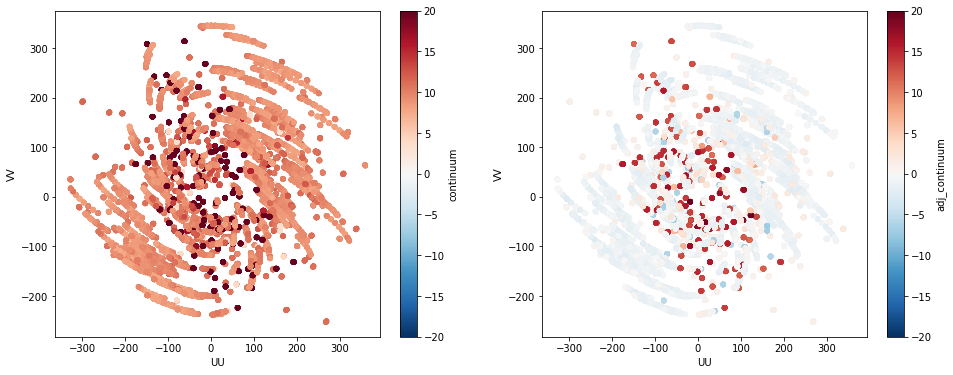

In [12]:
import numpy as np
import pandas as pd
import time

# start the race
start = time.time()

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

################################################################
# lets define a sequence of calculations as follows:
# 1. apply flags (sets flagged data cells to nan)
# 2. average magnitude of cross products
# 3. subtract mean magnitude of each baseline from visibilities
# 4. filter out baselines with outlier mean noise
# 5. take the mean accross channels to get a continuum
# 6. plot the UV space
# note that variables ending in df are dataframes, otherwise they are numpy arrays

# retrieve the visibility and flag columns
flags = pdf.columns.values[pdf.columns.str.match('FLAG\d')]
data = pdf.columns.values[pdf.columns.str.match('DATA\d')]

# 1. apply flags (sets flagged data cells to nan)
pdf[data] = pdf[data].mask(pdf[flags].values)

# 2. average magnitude of cross products
vis = pdf[data].abs().values.reshape(len(pdf),2,-1).mean(axis=1)
chans = ['DATA'+str(ii) for ii in range(vis.shape[1])]
pdf = pdf.join(pd.DataFrame(vis, columns=chans)).drop(columns=flags.tolist()+data.tolist())

# 3. subtract mean magnitude of each baseline from visibilities
baselines = pdf.groupby(['ANTENNA1', 'ANTENNA2'])
vis = baselines[chans].apply(lambda row: (row - row.mean(axis=0))).values
achans = ['adj_'+chan for chan in chans]
pdf = pdf.join(pd.DataFrame(vis, columns=achans))

# 4. filter out baselines with outlier mean noise
baselines = pdf.groupby(['ANTENNA1', 'ANTENNA2'])
noise = np.mean(baselines[chans].mean().values) # continuum noise
std_noise = np.std(baselines[chans].mean().mean(axis=1)) # std of continuum noise per baseline
pdf = baselines.filter(lambda row: np.abs(row[chans].mean(0).mean() - noise) < std_noise)

# 5. take the mean accross channels to get a continuum
pdf = pdf.assign(continuum = pdf[chans].mean(axis=1), adj_continuum = pdf[achans].mean(axis=1))

################################################################
print('pandas elapsed time (s): ', time.time() - start)

# 6. plot the UV space
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(16,6))
pdf.plot(x='UU', y='VV', c='continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[0])
pdf.plot(x='UU', y='VV', c='adj_continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[1])

#  CPU Processing with Apache Spark
https://spark.apache.org/docs/latest/api/python/index.html

https://spark.apache.org/docs/latest/rdd-programming-guide.html

In [5]:
# install and configure PySpark
import os
print("installing spark...")
os.system("apt-get install openjdk-8-jdk-headless -qq")
os.system("pip install findspark")
os.system("wget https://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz")
os.system("tar -xvzf spark-2.4.3-bin-hadoop2.7.tgz")

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"
print('complete') 

installing spark...
complete


In [6]:
print('initializing spark...') 
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.memory', '6g')
spark = spark.config('spark.executor.memory', '4g')
spark = spark.config('spark.executor.instances', '1')  # ignored in local mode
spark = spark.config('spark.executor.cores', '4')      # pretty sure this is ignored too
spark = spark.config('spark.sql.execution.arrow.enabled', 'True')
spark = spark.master("local[*]").getOrCreate()
spark.sparkContext._conf.getAll() 

initializing spark...


[('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.executor.cores', '4'),
 ('spark.driver.host', '00f02cd6c385'),
 ('spark.driver.memory', '6g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.instances', '1'),
 ('spark.driver.port', '37557'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1563972543269'),
 ('spark.sql.execution.arrow.enabled', 'True'),
 ('spark.ui.showConsoleProgress', 'true')]

spark elapsed time (s):  75.46551060676575


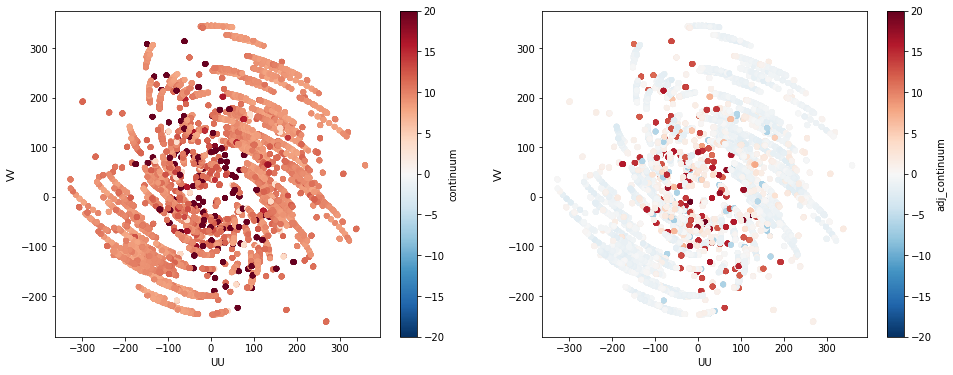

In [13]:
import numpy as np
import pandas as pd
import time
from pyspark.sql import Row

# start the race
start = time.time()

# load spark dataframe
sdf = spark.read.parquet(prefix+'.parquet')

################################################################
# lets define a sequence of calculations as follows:
# 1. apply flags (sets flagged data cells to nan)
# 2. average magnitude of cross products
# 3. subtract mean magnitude of each baseline from visibilities
# 4. filter out baselines with outlier mean noise
# 5. take the mean accross channels to get a continuum
# 6. plot the UV space
# note that variables ending in rdd are resilient distributed datasets

def flag_and_mean(row):
  # 1. apply flags (sets flagged data cells to nan)
  vis0 = np.ma.masked_array(row['DATA0R'] + 1j*np.array(row['DATA0I'], dtype=np.complex), row['FLAG0'])
  vis1 = np.ma.masked_array(row['DATA1R'] + 1j*np.array(row['DATA1I'], dtype=np.complex), row['FLAG1'])
  # 2. average magnitude of cross products
  vis = ((np.abs(vis0) + np.abs(vis1))/2).filled(np.nan) # fill masked values with nan
  return [vis, row['UU'], row['VV']] 

srdd = sdf.rdd.keyBy(lambda rr: str(rr['ANTENNA1'])+' '+str(rr['ANTENNA2']))
srdd = srdd.mapValues(lambda rr: flag_and_mean(rr))

brdd = srdd.groupByKey()
nrdd = brdd.mapValues(lambda grp: np.nanmean([row[0] for row in grp])).values()
noise = nrdd.mean()
std_noise = nrdd.stdev()

# 3. subtract mean magnitude of each baseline from visibilities
def subtract_noise(group):
  vis = np.array([row[0] for row in group])
  uu = np.array([row[1] for row in group])
  vv = np.array([row[2] for row in group])
  adj_vis = vis - np.nanmean(vis, axis=0)
  return [vis, adj_vis, uu, vv]

# 4. filter out baselines with outlier mean noise
frdd = brdd.mapValues(subtract_noise).filter(lambda gp: np.abs(np.nanmean(gp[1][0])-noise) < std_noise)

# 5. take the mean accross channels to get a continuum
vrdd = frdd.map(lambda gp: [np.nanmean(gp[1][0],axis=1),np.nanmean(gp[1][1],axis=1),gp[1][2],gp[1][3]])

# collect results
vds = vrdd.collect()  

################################################################
print('spark elapsed time (s): ', time.time() - start)

# 6. plot the UV space
import matplotlib.pyplot as plt

continuum = np.hstack([vds[ii][0] for ii in range(len(vds))])
adj_continuum = np.hstack([vds[ii][1] for ii in range(len(vds))])
uu = np.hstack([vds[ii][2] for ii in range(len(vds))])
vv = np.hstack([vds[ii][3] for ii in range(len(vds))])
pdf = pd.DataFrame({'continuum':continuum,'adj_continuum':adj_continuum,'UU':uu,'VV':vv})
fig, axes = plt.subplots(1,2, figsize=(16,6))
pdf.plot(x='UU', y='VV', c='continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[0], )
pdf.plot(x='UU', y='VV', c='adj_continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[1])

# CPU Processing with Dask
https://examples.dask.org/dataframe.html

In [2]:
# if you've been doing other things, you might want to refresh the runtime before doing this
# go to Runtime -> Restart runtime
# then execute the prefix cell at the top to reset the prefix (data files will be kept on disk)

print("installing dask...")
!pip install partd > /dev/null
!pip install dask > /dev/null

from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='8GB')
client

installing dask...


Client Scheduler: inproc://172.28.0.2/915/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 8.00 GB


dask elapsed time (s):  159.92977499961853


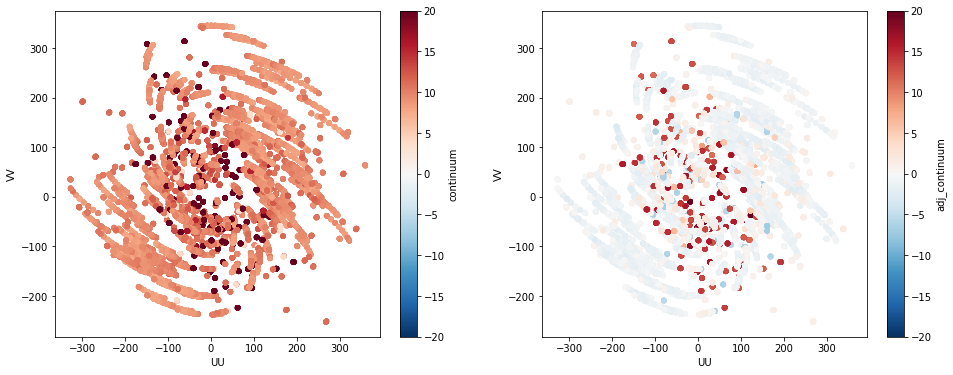

In [6]:
import numpy as np
import dask.dataframe as dd
import dask.array as da
import time

CHUNK = 5000

# start the race
start = time.time()

# load dask dataframe
ddf = dd.read_hdf(prefix+'.h5', key='mdf', chunksize=CHUNK)

################################################################
# lets define a sequence of calculations as follows:
# 1. apply flags (sets flagged data cells to nan)
# 2. average magnitude of cross products
# 3. subtract mean magnitude of each baseline from visibilities
# 4. filter out baselines with outlier mean noise
# 5. take the mean accross channels to get a continuum
# 6. plot the UV space
# note that variables ending in df are dataframes, otherwise they are numpy arrays

# retrieve the visibility and flag columns
# these are dask arrays, not numpy arrays 
# they hold no value until .compute() is called later on (lazy execution)
flags = list(ddf.columns.values[ddf.columns.str.match('FLAG\d')])
data = list(ddf.columns.values[ddf.columns.str.match('DATA\d')])

# 1. apply flags (sets flagged data cells to nan)
vis = da.ma.masked_array(ddf[data].to_dask_array(True), ddf[flags].to_dask_array(True))

# 2. average magnitude of cross products
vis = (np.abs(vis[:,:len(data)//2]) + np.abs(vis[:,len(data)//2:]))/2.0 
chans = ['DATA'+str(ii) for ii in range(len(data)//2)]
ddf[chans] = dd.from_dask_array(da.ma.filled(vis, fill_value=np.nan), index=ddf.index)
ddf = ddf.drop(data+flags, axis=1)

# initialize some new columns in our dataframe
achans = ['adj_'+cc for cc in chans]
ddf[achans] = dd.from_dask_array(ddf[chans].values, index=ddf.index)
ddf['base_noise'] = np.nan

# 3. subtract mean magnitude of each baseline from visibilities
baselines = ddf.groupby(['ANTENNA1', 'ANTENNA2']) # select by baseline
def subtract_mean(grp):
  cnoise = np.mean(grp[chans], axis=0).values # per-channel noise
  grp.loc[:,achans] = (grp[chans] - cnoise).values
  grp.loc[:,'base_noise'] = np.mean(cnoise) #continuum noise of baseline
  return grp 

ddf = baselines.apply(subtract_mean, meta=dict(ddf.dtypes))

# 4. filter out baselines with outlier mean noise
noise = ddf['base_noise'].unique()
ddf = ddf[(ddf['base_noise'] - noise.mean()).abs() < noise.std()]

# 5. take the mean accross channels to get a continuum
ddf = ddf.assign(continuum = ddf[chans].mean(axis=1), adj_continuum = ddf[achans].mean(axis=1))

pdf = ddf[['UU','VV','continuum', 'adj_continuum']].compute()

################################################################
print('dask elapsed time (s): ', time.time() - start)

# 6. plot the UV space
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(16,6))
pdf.plot(x='UU', y='VV', c='continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[0])
pdf.plot(x='UU', y='VV', c='adj_continuum', kind='scatter', vmin=-20, vmax=20, cmap='RdBu_r', ax=axes[1])

In [0]:
client.close()

# GPU Processing with Tensorflow
https://www.tensorflow.org/api_docs/python/tf

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

d0 = pdf.columns.values[pdf.columns.str.startswith('DATA0_')]
d1 = pdf.columns.values[pdf.columns.str.startswith('DATA1_')]

start = time.time()

###########################################################################
# create our tensor math sequence
with tf.device('/gpu:0'):
  c0 = pdf[d0].values  # first set of complex visibilities
  c1 = pdf[d1].values  # second set of complex visibilities
  
  aa = tf.placeholder(tf.complex64, shape=c0.shape)
  bb = tf.placeholder(tf.complex64, shape=c1.shape)
  tvis = tf.scalar_mul(0.5, tf.add(aa, bb))
  
  # lets do some math to take up time
  tCONT_RMS = tf.sqrt( tf.reduce_mean( tf.square( tf.abs(tvis) ), axis=1) )          
  tCONT_MAX = tf.reduce_max( tf.abs(tvis), axis=1)
  tCONT_STD = tf.math.reduce_std( tf.abs(tvis), axis=1)

with tf.Session() as sess:    
    vis = sess.run(tvis, feed_dict={aa: c0, bb: c1})
    CONT_RMS = sess.run(tCONT_RMS, feed_dict={aa: c0, bb: c1})
    CONT_MAX = sess.run(tCONT_MAX, feed_dict={aa: c0, bb: c1})
    CONT_STD = sess.run(tCONT_STD, feed_dict={aa: c0, bb: c1})

###########################################################################

print('tensorflow elapsed time (s): ', time.time() - start)

print(vis[99,:10])
print(CONT_RMS)
print(CONT_MAX)
print(CONT_STD)

tensorflow elapsed time (s):  2.854881763458252
[13.544712  -4.1790752j  11.385413  -1.468117j    6.5120544 -0.63292366j
  4.2294087 -8.978855j   16.402962  -3.087995j    7.351376  -1.7305609j
  4.109383  -3.5484805j  10.181942  -1.7112226j   9.926709  -4.0611053j
  4.697096 -13.006346j  ]
[10.410055 10.482974 10.374873 ... 10.956581 10.379413  8.499947]
[25.624916 21.068535 21.712816 ... 29.41013  27.530628 27.838688]
[4.1418676 4.1568103 3.8755555 ... 5.051679  4.639209  4.07304  ]


# Brief Intro to Dataframes
The MS is now represented as a Dataframe in Python.  Most of these examples will leverage that structure as the Dataframe concept is used by Pandas, Spark, and Dask.  Here is a brief tutorial for those unfamiliar with the original Pandas Dataframe concept.

Pandas is a popular data analytics package for Python built over numpy and matplotlib.  Subsequent frameworks such as Spark have extended the Pandas concept to parallel/scalable processing.

https://pandas.pydata.org/


BTW, variable names that end in 'df' are dataframes

In [0]:
import pandas as pd
import numpy as np

# load pandas dataframe
pdf = pd.read_hdf(prefix+'.h5', key='mdf')

# what do we have here?
print(pdf.columns)  # add .values to return as numpy array instead of pandas type

# this is a quick way to inspect the dataframe
pdf.head()

Index(['FLAG0', 'FLAG1', 'FLAG_CATEGORY', 'WEIGHT0', 'WEIGHT1', 'SIGMA0',
       'SIGMA1', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID',
       ...
       'DATA1_374', 'DATA1_375', 'DATA1_376', 'DATA1_377', 'DATA1_378',
       'DATA1_379', 'DATA1_380', 'DATA1_381', 'DATA1_382', 'DATA1_383'],
      dtype='object', length=795)


,FLAG0,FLAG1,FLAG_CATEGORY,WEIGHT0,WEIGHT1,SIGMA0,SIGMA1,ANTENNA1,ANTENNA2,ARRAY_ID,DATA_DESC_ID,EXPOSURE,FEED1,FEED2,FIELD_ID,FLAG_ROW,INTERVAL,OBSERVATION_ID,PROCESSOR_ID,SCAN_NUMBER,STATE_ID,TIME,TIME_CENTROID,WEIGHT_SPECTRUM,UU,VV,WW,DATA0_0,DATA0_1,DATA0_2,DATA0_3,DATA0_4,DATA0_5,DATA0_6,DATA0_7,DATA0_8,DATA0_9,DATA0_10,DATA0_11,DATA0_12,...,DATA1_344,DATA1_345,DATA1_346,DATA1_347,DATA1_348,DATA1_349,DATA1_350,DATA1_351,DATA1_352,DATA1_353,DATA1_354,DATA1_355,DATA1_356,DATA1_357,DATA1_358,DATA1_359,DATA1_360,DATA1_361,DATA1_362,DATA1_363,DATA1_364,DATA1_365,DATA1_366,DATA1_367,DATA1_368,DATA1_369,DATA1_370,DATA1_371,DATA1_372,DATA1_373,DATA1_374,DATA1_375,DATA1_376,DATA1_377,DATA1_378,DATA1_379,DATA1_380,DATA1_381,DATA1_382,DATA1_383
0,                                              ...,                                              ...,False,20.415682,26.796448,0.221319,0.193180,1,2,0,0,6.048,0,0,0,False,6.048,0,2,4,0,4.860027e+09,4.860027e+09,False,95.583330,-138.672313,-13.694759,(2.3318817615509033-3.5661864280700684j),(8.517426490783691+5.2483296394348145j),(16.66013526916504+6.8231987953186035j),(7.182509422302246+0.08891031891107559j),(10.832413673400879+4.374227046966553j),(0.6358211636543274-0.7716213464736938j),(2.1642746925354004+4.399510860443115j),(8.17321491241455+2.7197201251983643j),(13.39111614227295-6.9550018310546875j),(3.2065072059631348-4.231297969818115j),(15.346712112426758-4.567995548248291j),(19.855609893798828-5.028872966766357j),(5.813932418823242-6.026472091674805j),...,(17.27989959716797+3.3604886531829834j),(8.177420616149902+1.6735318899154663j),(-0.02199137955904007+5.626868724822998j),(20.410009384155273+2.8687903881073j),(3.341310977935791-1.4374526739120483j),(12.33537769317627-4.610698699951172j),(7.492038249969482+6.322351932525635j),(1.3734248876571655-3.6436853408813477j),(1.4769983291625977-0.6867740154266357j),(6.017889022827148+7.395653247833252j),(9.560358047485352-1.985134243965149j),(15.66563606262207-6.449517726898193j),(-4.336203575134277-2.210480213165283j),(-4.779181957244873-6.1192169189453125j),(2.266981363296509+4.905197620391846j),(12.975719451904297-0.42215049266815186j),(4.979161262512207+4.769021987915039j),(4.713338375091553+7.099242210388184j),(4.052988052368164-3.435676336288452j),(3.669857978820801-2.0122134685516357j),(12.932084083557129+0.7047814130783081j),(5.075198650360107-6.040958404541016j),(10.913556098937988+1.3338634967803955j),(9.331941604614258-2.9620518684387207j),(1.9388401508331299-0.5656161904335022j),(14.282381057739258-3.0161337852478027j),(14.715849876403809-3.7254133224487305j),(17.191993713378906-2.0113627910614014j),(2.9381611347198486+3.5896992683410645j),(17.237485885620117-4.860803127288818j),(15.538578987121582+6.01350212097168j),(8.076106071472168-5.437648296356201j),(5.798494338989258+7.236459255218506j),(7.976403713226318+1.227457046508789j),(8.4287109375+5.924354076385498j),(4.802339553833008-8.367317199707031j),(12.765170097351074+2.8492603302001953j),(12.333675384521484-0.745797872543335j),(21.547746658325195+4.049798965454102j),(13.551788330078125-0.7658910751342773j)
1,                                              ...,                                              ...,False,19.593037,33.047886,0.225917,0.173951,1,3,0,0,6.048,0,0,0,False,6.048,0,2,4,0,4.860027e+09,4.860027e+09,False,-111.767122,28.948793,42.888321,(20.93869400024414+0.7156710028648376j),(6.29837703704834-9.540606498718262j),(11.93618392944336+5.157202243804932j),(7.319814205169678+4.718991756439209j),(14.039151191711426-5.33660364151001j),(1.3295425176620483-3.44425630569458j),(15.372822761535645-10.89024543762207j),(8.993243217468262+5.282325744628906j),(2.019103527069092-4.335098743438721j),(8.965170860290527+18.955461502075195j),(3.09230637550354+4.113480567932129j),(5.451208591461182-1.2571710348129272j),(1.309105634689331+3.7018072605133057j),...,(22.81267738342285-7.453534126281738j),(1.7387911081314087-14.087273597717285j),(5.526534080505371-12.111541748046875j

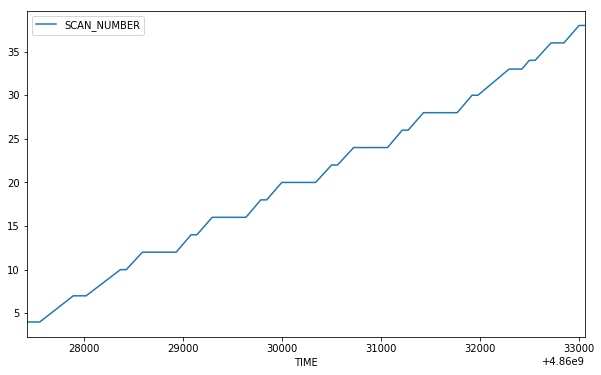

In [0]:
# you can easily visualize things
pdf.plot(x='TIME', y='SCAN_NUMBER', figsize=(10,6));

In [0]:
# one column of a DataFrame is a Series
# you can do math on a Series as you would a numpy array
# the result is a new Series
vis = (pdf.DATA0_0 + pdf.DATA1_0)/2
print(type(vis))
vis.head()

<class 'pandas.core.series.Series'>


0      (8.575416684150696-1.6929169222712517j)
1      (17.93399953842163-2.9816539585590363j)
2      (11.509327411651611+2.421016186475754j)
3    (-0.1800689697265625+6.2383646965026855j)
4      (18.771233081817627+5.290798768401146j)
dtype: complex128

(384,)
(80563,)
(80563, 384) (80563,)


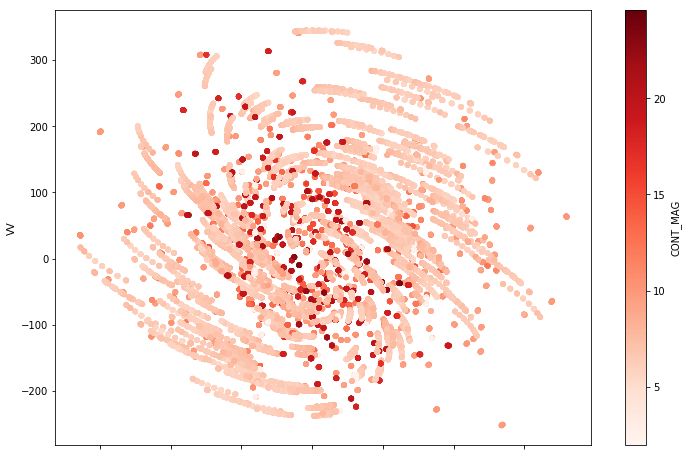

In [0]:
# we can do operations on a slice of multiple columns
# here we will operate on all the visibility channels (each in their own column)
d0 = pdf.columns.values[pdf.columns.str.startswith('DATA0_')]
d1 = pdf.columns.values[pdf.columns.str.startswith('DATA1_')]

# we can find the mean across time for each channels
print(pdf[d0].mean(axis=0).shape)

# and the mean across channels for each time
print(pdf[d0].mean(axis=1).shape)

# but you can't add dataframe slices with different column names
# i.e. pdf[d0] + pdf[d1] wont work
# but you can add their underlying numpy arrays
vis = (pdf[d0].values + pdf[d1].values)/2

# let's compute the continuum average across channels and store that back in the df
pdf['CONT_MAG'] = np.mean(np.abs(vis), axis=1)
print(vis.shape, pdf['CONT_MAG'].values.shape)

# and visualize
from matplotlib import cm
pdf.plot(x='UU', y='VV', c='CONT_MAG', kind='scatter', cmap=cm.get_cmap('Reds'), figsize=(12,8))

In [0]:
# maybe we want to see things per antenna and/or baseline
# let's see how much each antenna mean varies from the global
vis_mean = pdf['CONT_MAG'].mean()
ant_mean = pdf.groupby('ANTENNA1')['CONT_MAG'].mean()
print('per antenna means', ant_mean.values)

# which antenna has the highest/lowest signal mean?
print('max antenna: ', ant_mean.idxmax(), '\nmin antenna: ', ant_mean.idxmin())
print('a coincidence?')

#print('ant1 noise / global noise: ', ant1_means / vis_mean)

# now lets look per baseline
base_mean = pdf.groupby(['ANTENNA1', 'ANTENNA2'])['CONT_MAG'].mean()
print('baseline count: ', len(base_mean), '\nmax baseline / value: ', base_mean.idxmax(), base_mean.max(), 
      '\nmin baseline / value: ', base_mean.idxmin(), base_mean.min())

per antenna means [6.89266775 7.83340839 7.58132396 7.59792542 7.25306602 7.65313135
 7.29746455 7.61110276 7.599869   7.52692118 8.06751046 7.76737986
 7.62077569 8.13920066 7.25198139 7.52270285 8.18141661 7.31816699
 7.92256002 9.65838888]
max antenna:  24 
min antenna:  1
a coincidence?
baseline count:  210 
max baseline / value:  (24, 25) 9.658388878949763 
min baseline / value:  (21, 22) 5.611508502831316
